Linear regression is somewhat trivial and is basically linear algebra with some regualator maybe and some good feature model etc. We will instead look at what ML can give us. Regression should hopefully be the most basic of all the ML-model, since we have some data and target and want to minimize L2-norm (if error is Guassian).   

In [45]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

We will look (as usual) at the mnist dataset.

In [3]:
# MNIST dataset parameters.
num_classes = 10 # 0 to 9 digits
num_features = 784 # 28*28

# Training parameters.
learning_rate = 0.01
training_steps = 1000
batch_size = 256
display_step = 50

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [56]:
class logits_layer(keras.layers.Layer):
    def __init__(self):
        super(logits_layer, self).__init__()
        self.units = 10

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs): 
        x = tf.matmul(inputs, self.W) + self.b
        y = tf.exp(x) / tf.reduce_sum(tf.exp(x))
        return y

class logits_model(keras.Model):
    def __init__(self):
        super(logits_model, self).__init__()
        self.block_1 = logits_layer()

    def call(self, inputs):
        x = self.block_1(inputs)
        return x

In [76]:
optimizer = tf.optimizers.SGD(learning_rate)
epochs = 10
loss_history = []

model = logits_model()


for epoch in range(epochs):
    for image, label in train_data.take(training_steps):
        with tf.GradientTape() as tape:
            y_pred = model(image)
            y_true  = tf.one_hot(label, depth=num_classes)
            y_pred  = tf.clip_by_value(y_pred, 1e-9, 1.)
            loss = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))
            
        loss_history.append(loss.numpy())
        varib = model.trainable_variables
        gradients = tape.gradient(loss, varib)
        optimizer.apply_gradients(zip(gradients, varib))

In [77]:
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

pred = model(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.900400


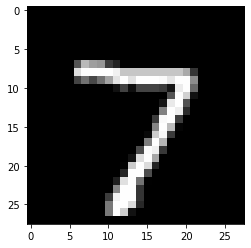

Model prediction: 7


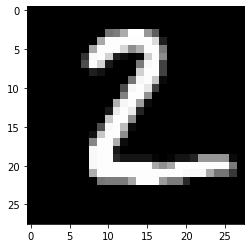

Model prediction: 2


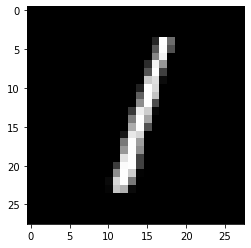

Model prediction: 1


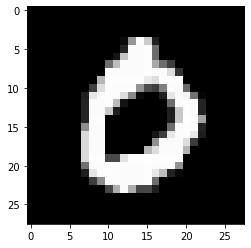

Model prediction: 0


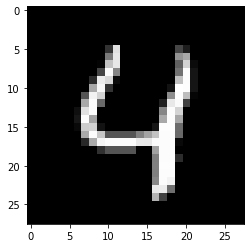

Model prediction: 4


In [78]:
import matplotlib.pyplot as plt

n_images = 5
test_images = x_test[:n_images]
predictions = model(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

Text(0, 0.5, 'Loss [entropy]')

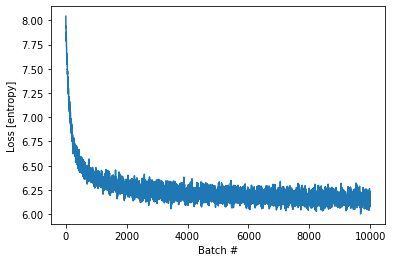

In [79]:
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')